In [2]:
import math
import numpy as np
from scipy import interpolate
import cv2
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
sigma = 1.75
alpha = 100.0
eps = 0.0000002
sigmaSq = sigma*sigma
invSigmaSq = 1.0/sigmaSq
mutations = 32*256*256
checkpoints = 1000

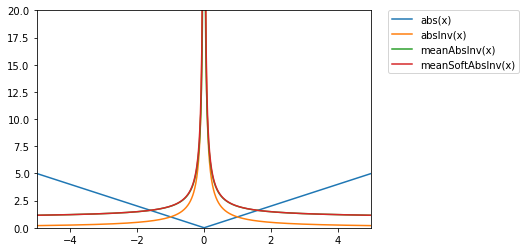

In [18]:
def draw_ellipse(
        img, center, axes, angle,
        startAngle, endAngle, color,
        thickness=1, lineType=cv2.LINE_AA, shift=10):
    center = (
        int(round(center[0] * 2**shift)),
        int(round(center[1] * 2**shift))
    )
    axes = (
        int(round(axes[0] * 2**shift)),
        int(round(axes[1] * 2**shift))
    )
    startAngle = int(round(startAngle* 2**shift))
    cv2.ellipse(
        img, center, axes, angle,
        startAngle, endAngle, color,
        thickness, lineType, shift)
    
def softAbs(x, a):
    return np.where(np.absolute(x) > eps,x/np.tanh(a*x),1.0/a)

def softAbsInv(x, a):
    return np.reciprocal(softAbs(x,a))

def convAbs(x, a):
    return (a*np.abs(x)+1)/a

def convAbsInv(x, a):
    return np.reciprocal(convAbs(x,a))

def upAbs(x, a):
    return (np.abs(x)+a)/a

def upAbsInv(x, a):
    return np.reciprocal(upAbs(x,a))

def upSoftAbsInv(x, aUp, aSoft):
    return upAbs(softAbsInv(x,aSoft),aUp)

def softUpAbsInv(x, aUp, aSoft):
    return softAbs(upAbsInv(x,aUp),aSoft)

def meanAbsInv(x, a):
    return (convAbsInv(x, a)+upAbsInv(x, a))

def meanSoftAbsInv(x, a):
    return (softAbsInv(x, a)+upAbsInv(x, a))


x = np.linspace(-5.,5., num=1000)

plt.plot(x, np.abs(x), '-', label="abs(x)")
plt.plot(x, 1.0/np.abs(x), '-', label="absInv(x)")
plt.plot(x, meanAbsInv(x,alpha), '-', label="meanAbsInv(x)")
plt.plot(x, meanSoftAbsInv(x,alpha), '-', label="meanSoftAbsInv(x)")
#plt.plot(x, softAbsInv(x,alpha), '-', label="softAbsInv")
#plt.plot(x, meanSoftAbsInv(x,alpha), '-', label="meanSoftAbsInv")
plt.axis([-5, 5, 0, 20])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
    

In [19]:
img_1 = cv2.imread('lena.jpg',0)
img_2 = cv2.imread('radial_gradient.png',0)
img_3 = cv2.imread('Y8UeF.jpg',0)

dim = 255
x = range(0,dim)
y = range(0,dim)
xx, yy = np.meshgrid(np.array(x), np.array(y), sparse=True)
img_4 = 255*np.exp(-((xx-0.25*dim)**2 + (yy-0.25*dim)**2)/(0.1*255.0)**2)+255*np.exp(-((xx-0.65*dim)**2 + (yy-0.65*dim)**2)/(0.2*255.0)**2)
img_5 = 255*np.exp(-((xx-0.5*dim)**2 + (yy-0.5*dim)**2)/(0.2*255.0)**2)*np.cos(((xx-0.5*dim)**2 + (yy-0.5*dim)**2)/(5.0*255.0))**2
img_6 = 255*np.exp(-((xx-0.5*dim)**2/(0.30*255.0)**2 + (yy-0.5*dim)**2/(0.015*255.0)**2))

         
img_1 = img_1+3.0       
img_2 = img_2+3.0
img_3 = img_3+3.0
img_4 = img_4+3.0
img_5 = img_5+3.0
img_6 = img_6+3.0


img_1 = img_1/img_1.max()
img_2 = img_2/img_2.max()
img_3 = img_3/img_3.max()
img_4 = img_4/img_4.max()
img_5 = img_5/img_5.max()
img_6 = img_6/img_6.max()

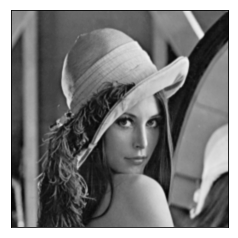

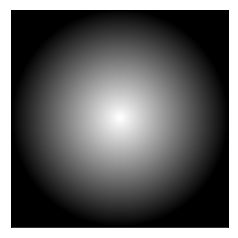

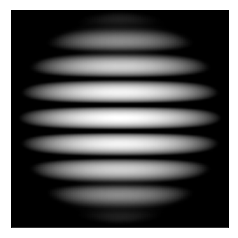

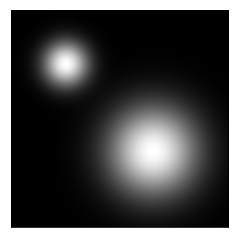

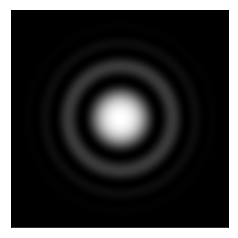

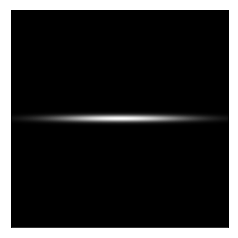

In [20]:
plt.imshow(img_1, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(img_2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(img_3, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(img_4, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(img_5, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(img_6, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [21]:
class ImgDensity(object):
    def __init__(self, img):
        self.img = img.T
        self.height, self.width = img.shape[:2]
        self.dx = 1.0
        self.dy = 1.0
        self.x = np.arange(self.width)
        self.y = np.arange(self.height)
        self.xx, self.yy = np.meshgrid(self.x, self.y)
        self.z = self.img[self.xx, self.yy]
        self.f = interpolate.interp2d(self.x, self.y, self.z, kind='linear', fill_value=img.min())
        #self.f = interpolate.RectBivariateSpline(self.x, self.y, self.z)
        
    def getDensity(self,xp,yp):
        return self.f(xp,yp)
    
    def getLogDensity(self,xp,yp):
        return math.log(self.getDensity(xp,yp))
    
    def getGradLogDensity(self,xp,yp):
        #return np.gradient(self.getLogDensity(xp,yp))
        #return 0.5*np.array([(self.getLogDensity(xp+self.dx,yp)-self.getLogDensity(xp-self.dx,yp))/self.dx,
        #                     (self.getLogDensity(xp,yp+self.dy)-self.getLogDensity(xp,yp-self.dy))/self.dy])
        logDensity = self.getLogDensity(xp, yp)
        return np.array([(self.getLogDensity(xp+self.dx,yp)-logDensity)/self.dx,
                             (self.getLogDensity(xp,yp+self.dy)-logDensity)/self.dy])
    
    def getHessLogDensity(self,xp,yp):
        #return hessian(self.getLogDensity(xp,yp))
        #return 0.5*np.array([[(self.getGradLogDensity(xp+self.dx,yp)[0]-self.getGradLogDensity(xp-self.dx,yp)[0])/self.dx,
        #                     (self.getGradLogDensity(xp,yp+self.dy)[0]-self.getGradLogDensity(xp,yp-self.dy)[0])/self.dy],
        #                    [(self.getGradLogDensity(xp+self.dx,yp)[1]-self.getGradLogDensity(xp-self.dx,yp)[1])/self.dy,
        #                     (self.getGradLogDensity(xp,yp+self.dy)[1]-self.getGradLogDensity(xp,yp-self.dy)[1])/self.dx]])
        gradLogDensity = self.getGradLogDensity(xp, yp)
        return np.array([[(self.getGradLogDensity(xp+self.dx,yp)[0]-gradLogDensity[0])/self.dx,
                             (self.getGradLogDensity(xp,yp+self.dy)[0]-gradLogDensity[0])/self.dy],
                            [(self.getGradLogDensity(xp+self.dx,yp)[1]-gradLogDensity[1])/self.dy,
                             (self.getGradLogDensity(xp,yp+self.dy)[1]-gradLogDensity[1])/self.dx]])
    
    def getPreLogDensity(self,xp,yp):
        
        eigenValues, eigenVector = np.linalg.eig(-1.0*self.getHessLogDensity(xp,yp))
        
        softAbsCov = meanAbsInv(eigenValues, alpha)
        
        softAbsCov = softAbsCov/np.amax(softAbsCov)
        
        return np.matmul(np.matmul(eigenVector, np.diag(softAbsCov)), eigenVector.T)

    
    def logProposalDensity(self, x0, x1, y0, y1):
        gradient = self.getGradLogDensity(x0, x1)
        preCond = self.getPreLogDensity(x0, x1)
        
        return -np.linalg.norm(np.array([y0,y1])-np.array([x0,x1])-0.5*sigmaSq * np.matmul(preCond, gradient).T)**2 / (2 * sigmaSq)
        

In [22]:
class MultivariateNormal(object):
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        self.eigenValue, self.eigenVector = np.linalg.eig(self.cov)
        self.scale = np.multiply(np.abs(self.eigenValue), np.array([np.linalg.norm(self.eigenVector[0,:], ord=2), 
                                                           np.linalg.norm(self.eigenVector[0,:], ord=2)]))
        self.angle = math.degrees(math.atan2(-self.eigenVector[0,1], self.eigenVector[0,0]))
        
    def getSample(self, width, height):
        return np.random.multivariate_normal(self.mean, self.cov)
    

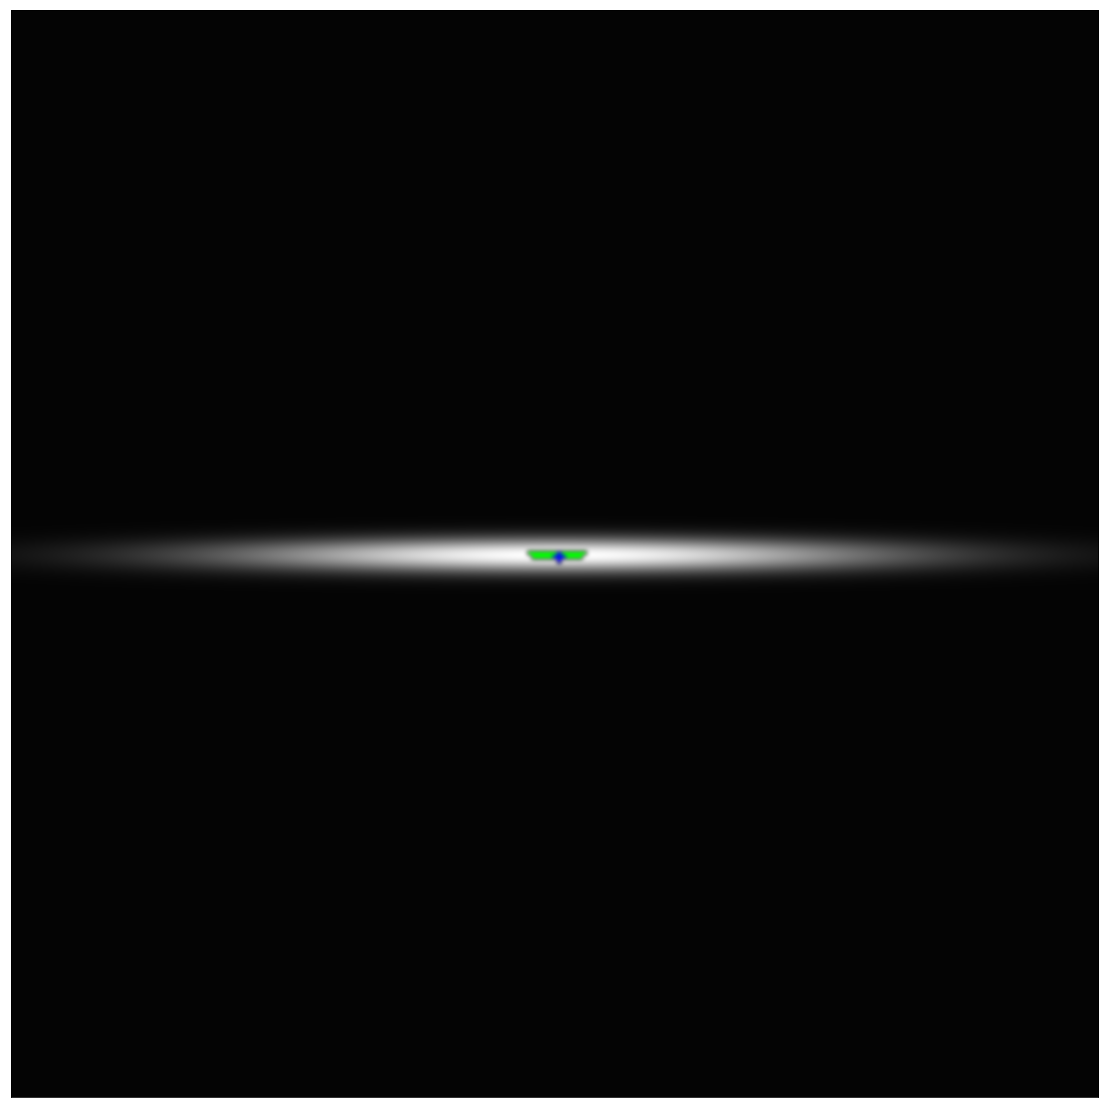

In [23]:
def testCov(img):

    imgDens = ImgDensity(img)

    x0 = imgDens.width/2
    x1 = imgDens.height/2
    Fx = imgDens.getLogDensity(x0, x1)

    
    binx0 = min(imgDens.width-1, max(int(round(x0)), 0))
    binx1 = min(imgDens.height-1, max(int(round(x1)), 0))
    
    mean = np.array([x0, x1])+0.5*sigmaSq*np.matmul(imgDens.getPreLogDensity(x0, x1),imgDens.getGradLogDensity(x0, x1).T)
    cov = sigmaSq*imgDens.getPreLogDensity(x0, x1)
    gaussian = MultivariateNormal(mean, cov)

    f = plt.figure(figsize=(20,20))
    
    img_temp = np.zeros((imgDens.height, imgDens.width,4))
    img_temp = np.zeros((imgDens.width, imgDens.height,4))
    img_temp[:,:,3] = 1.0-img/img.max()
    draw_ellipse(img_temp, tuple(gaussian.mean), tuple(gaussian.scale), int(gaussian.angle), 0,360, [1,0,0,1])
    draw_ellipse(img_temp, tuple(gaussian.mean), tuple(2.0*gaussian.scale), int(gaussian.angle), 0,360, [0,1,0,1])
    cv2.circle(img_temp, (binx0, binx1), 1, [0,0,1,1],-1)
    plt.imshow(img_temp, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

    plt.show()
testCov(img_6)    
    
    

i: 0
acceptance rate: 1.0


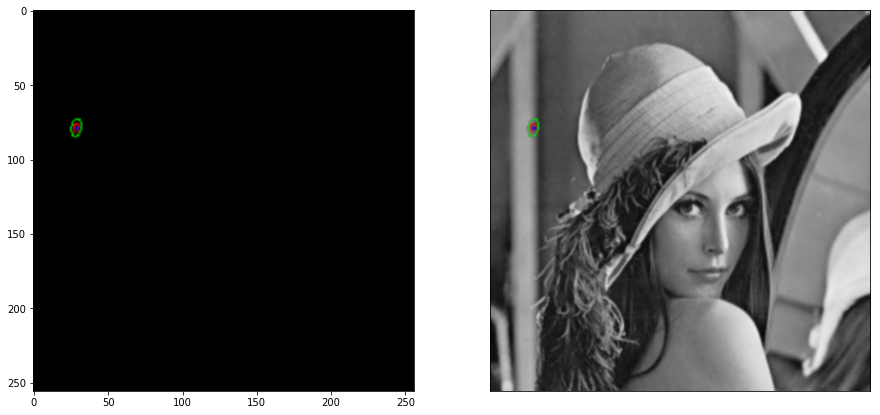

i: 1000
acceptance rate: 0.9200799200799201


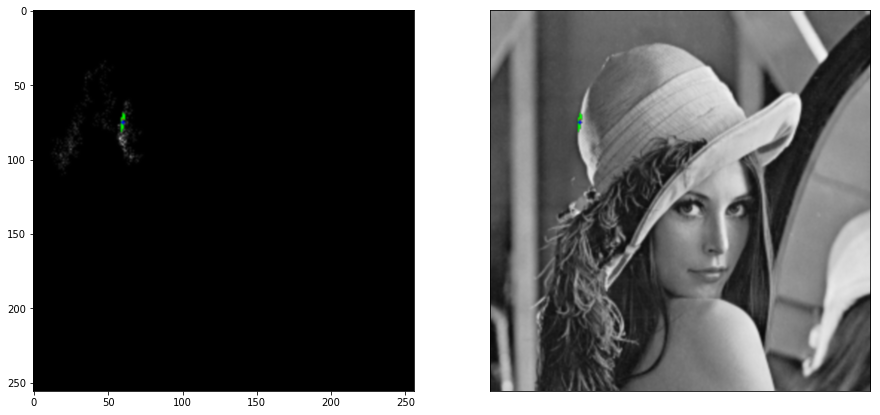

i: 2000
acceptance rate: 0.9060469765117442


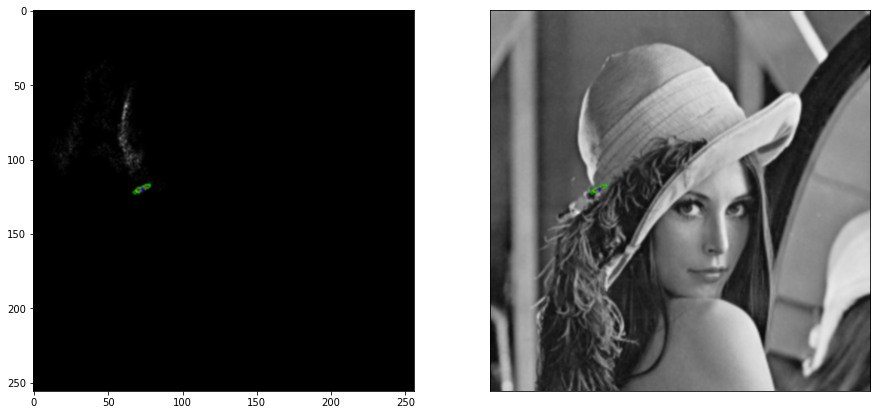

KeyboardInterrupt: 

In [24]:
def makeHistogram(img):
    
    imgDens = ImgDensity(img)
    histogram = np.zeros((imgDens.height, imgDens.width))
    
    x0 = random.randint(0,imgDens.width-1)
    x1 = random.randint(0,imgDens.height-1)
    Fx = imgDens.getLogDensity(x0, x1)
    
    binx0 = min(imgDens.width-1, max(int(round(x0)), 0))
    binx1 = min(imgDens.height-1, max(int(round(x1)), 0))
            
    
    mean = np.array([x0, x1])+0.5*sigmaSq*np.matmul(imgDens.getPreLogDensity(x0, x1),imgDens.getGradLogDensity(x0, x1).T)
    cov = sigmaSq*imgDens.getPreLogDensity(x0, x1)
    gaussian = MultivariateNormal(mean, cov)
    
    
    A = 0;
    for i in range(mutations):

        y0, y1 = gaussian.getSample(imgDens.width, imgDens.height)
        
        Fy = imgDens.getLogDensity(y0, y1)
        kxy = imgDens.logProposalDensity(x0, x1, y0, y1 )
        kyx = imgDens.logProposalDensity(y0, y1, x0, x1 )
        
        Axy = min(1, math.exp((Fy + kxy) - (Fx + kyx)))
        if (random.uniform(0,1) < Axy):
            A = A + 1
            x0 = y0
            x1 = y1
            Fx=Fy
            mean = np.array([x0,x1]) + 0.5*sigmaSq*np.matmul(imgDens.getPreLogDensity(x0, x1),imgDens.getGradLogDensity(x0, x1).T)
            cov = sigmaSq*imgDens.getPreLogDensity(x0, x1)
            gaussian = MultivariateNormal(mean, cov)
            
        binx0 = min(imgDens.width-1, max(int(round(x0)), 0))
        binx1 = min(imgDens.height-1, max(int(round(x1)), 0))
           
        if x0 < imgDens.width-1 and x0 > 0 and x1 < imgDens.height-1 and x1 > 0:
            histogram[binx0, binx1] += 1.0
        else:
            x0 = random.randint(0,imgDens.width-1)
            x1 = random.randint(0,imgDens.height-1)
            Fx = imgDens.getLogDensity(x0, x1)
    
            binx0 = min(imgDens.width-1, max(int(round(x0)), 0))
            binx1 = min(imgDens.height-1, max(int(round(x1)), 0))


            mean = np.array([x0, x1])+0.5*sigmaSq*np.matmul(imgDens.getPreLogDensity(x0, x1),imgDens.getGradLogDensity(x0, x1).T)
            cov = sigmaSq*imgDens.getPreLogDensity(x0, x1)
            gaussian = MultivariateNormal(mean, cov)
                
            
        if (i%checkpoints) == 0:
            ARate = float(A)/float(i+1)
            print('i: ' + repr(i))
            print('acceptance rate: ' + repr(ARate))
            
            f = plt.figure(figsize=(15,15))
            ax = f.add_subplot(121)
            ax2 = f.add_subplot(122)
            
            img_temp = np.zeros((imgDens.height, imgDens.width,4))
            if histogram.max() > 0:
                img_temp[:,:,3] = 1.0-histogram.T/histogram.max()
            else:
                img_temp[:,:,3] = 1.0-histogram.T
            draw_ellipse(img_temp, tuple(gaussian.mean), tuple(gaussian.scale), int(gaussian.angle), 0,360, [1,0,0,1])
            draw_ellipse(img_temp, tuple(gaussian.mean), tuple(2.0*gaussian.scale), int(gaussian.angle), 0,360, [0,1,0,1])
            cv2.circle(img_temp, (binx0, binx1), 1, [0,0,1,1],-1)
            ax.imshow(img_temp, interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            
            img_temp = np.zeros((imgDens.width, imgDens.height,4))
            img_temp[:,:,3] = 1.0-img/img.max()
            draw_ellipse(img_temp, tuple(gaussian.mean), tuple(gaussian.scale), int(gaussian.angle), 0,360, [1,0,0,1])
            draw_ellipse(img_temp, tuple(gaussian.mean), tuple(2.0*gaussian.scale), int(gaussian.angle), 0,360, [0,1,0,1])
            cv2.circle(img_temp, (binx0, binx1), 1, [0,0,1,1],-1)
            ax2.imshow(img_temp, interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            
            plt.show()
    
    ARate = float(A)/float(mutations)
    
    print('acceptance rate: ' + repr(ARate))
    print('histogram max value: ' + repr(histogram.max()))
    histogram =  255 * histogram / histogram.max()
    
    cv2.imwrite("MetropolisTest_Final.png" ,histogram)

makeHistogram(img_1)